### Grupo 24

Gabriel Antunes a101101
<br>
Guilherme Pinho a105533

<br>
Um sistema de tráfego é representado por um grafo orientado ligado. Os nodos denotam pontos de acesso e os arcos denotam vias de comunicação com apenas um sentido. O grafo tem de ser ligado: entre cada par de nodos <n1, n2> tem de existir um caminho n1 → n2 e um caminho n2 → n1.



1. Gerar aleatoriamente o grafo com  $$N \in\{6..10\}$$  nodos e com ramos verificando:

    i.  Cada nodo tem um número aleatório de descendentes $$d\in\{1 .. 3\}\,$$ cujos destinos são também gerados aleatoriamente. 
    
    ii. Se  existirem “loops” ou destinos repetidos, deve-se gerar outro grafo.
    
2. Pretende-se fazer  manutenção interrompendo  determinadas vias. Determinar o maior número de vias que é possível remover mantendo o grafo ligado.

Comecemos por inicilizar as varíaveis que vão definir o número de nodos do grafo principal e por construir esse mesmo grafo

In [438]:
import networkx as nx
import random
import matplotlib.pyplot as plt
from ortools.linear_solver import pywraplp

Num_Nodes = random.randint(6, 10)
List_Nodes = [n for n in range(1, Num_Nodes + 1)]

Definimos a função "verificar_conectividade" que para 2 nodos do gráfico vai verificar se existe pelo menos 1 caminho, tanto de ida como de volta

In [439]:
def verificar_conectividade(graph, start, end):
    return nx.has_path(graph, start, end) and nx.has_path(graph.reverse(), end, start)

A função makeGraph vai criar um grado com as condições estipuladas no enunciado

In [440]:
def makeGraph():

    graph = nx.DiGraph()            
    graph.add_nodes_from(List_Nodes)    # Cria um grafo direcionado com o número de nodos definidos aleatoriamnete no inicio do código

    for n1 in range(Num_Nodes):         # Vamos percorrer cada nodo do grafo
        List = List_Nodes.copy()        
        List.remove(List_Nodes[n1])     # O nodo selecionado é removido da lista para que não fique ligado a ele mesmo

        for _ in range(random.randint(1, 3)):   # Cada um dos nodos deve ter entre 1 e 3 sucessores
            if List:
                x = random.choice(List)
                if not graph.has_edge(List_Nodes[n1], x) and not graph.has_edge(x, List_Nodes[n1]): # Verificamos não existe já um caminho entre os 2 nodos, quer de ida quer de volta
                    graph.add_edge(List_Nodes[n1], x)
                    
    return graph

graph = makeGraph()

Apesar de já termos um grafo base temos de verificar se o grafo é fortemente ligado, e o programa vai criar novos grafos até que algum cumpra todos os requisitos

In [441]:
# Verificação de conectividade
for n in List_Nodes:
    for i in List_Nodes:
        if not verificar_conectividade(graph, n, i):
            graph = makeGraph()

O Grafo pedido na primeira parte do enunciado é o seguinte:

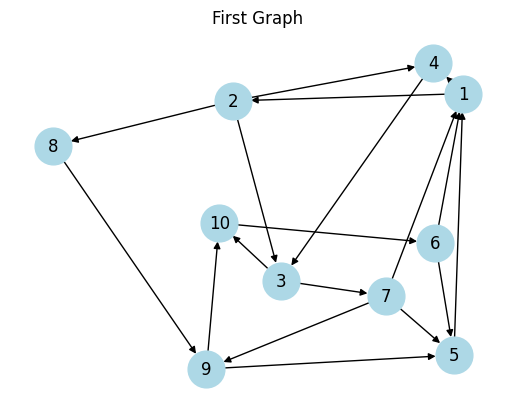

In [442]:
plt.title("First Graph")
nx.draw(graph, with_labels=True, node_color='lightblue', node_size=700, arrows=True)

Agora para a segunda parte do problema, vamos tentar retirar o maximo de arestas possiveis de forma a que o grafo continue a ser fortemente ligado

Começamos por inicializar o solver e as variáveis necessárias para que o solver resolva o problema

In [443]:
model = pywraplp.Solver.CreateSolver("SCIP")

# Adicionemos variáveis para cada aresta
edge_vars = {}

for u, v in graph.edges():
    edge_vars[(u, v)] = model.BoolVar(f"x_{u}_{v}")

Restrições para a resolução do modelo:

In [444]:
nodes = [n for n in graph.nodes()]
s = nodes.pop(0)

P = {}
# Restrições de Conectividade
for d in nodes:
       
    # Garantir que ha caminho de s para d
    paths = list(nx.all_simple_edge_paths(graph, s, d))
    N = len(paths)
    for i in range(N):
        P[(s,d,i)] = model.BoolVar(f"({s},{d},{i}")
        for edge in paths[i]:
            model.Add(P[(s,d,i)] <= edge_vars[edge])
    model.Add(sum([P[(s,d,i)] for i in range(N)])>=1)
    
    # Garantir que ha caminho de d para s
    paths = list(nx.all_simple_edge_paths(graph, d, s))
    N = len(paths)
    for i in range(N):
        P[(d,s,i)] = model.BoolVar(f"({d},{s},{i}")
        for edge in paths[i]:
            model.Add(P[(d,s,i)] <= edge_vars[edge])
    model.Add(sum([P[(d,s,i)] for i in range(N)])>=1)

model.Minimize(sum(edge_vars.values()))

O solver vai resolver o problema com base nas restrições impostas

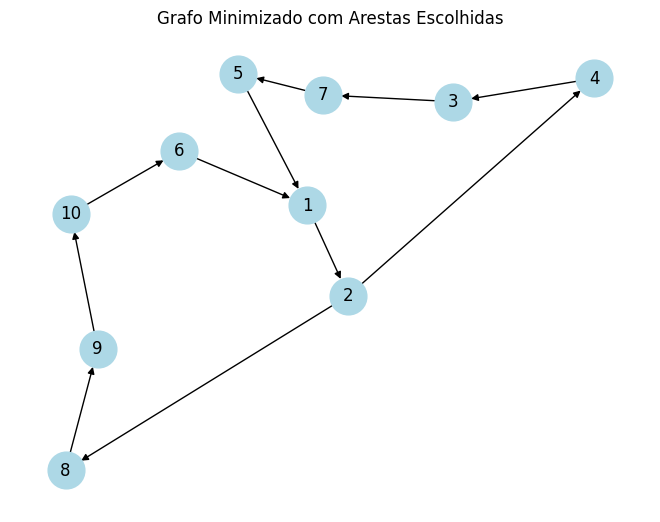

In [445]:
# Resolver o modelo
status = model.Solve()

# Verificar o status e imprimir resultados
if status == pywraplp.Solver.OPTIMAL:

    chosen_edges = [(u, v) for (u, v) in graph.edges() if edge_vars[(u, v)].solution_value() == 1]
    if chosen_edges:
        subgraph = graph.edge_subgraph(chosen_edges)
        nx.draw(subgraph, with_labels=True, node_color='lightblue', node_size=700, arrows=True)
        plt.title("Grafo Minimizado com Arestas Escolhidas")
        plt.show()
else:
    print("Sem solução")

### Consideremos alguns exemplos de grafos gerados por este algoritmo

### Exemplo1

Num_Nodes = 10


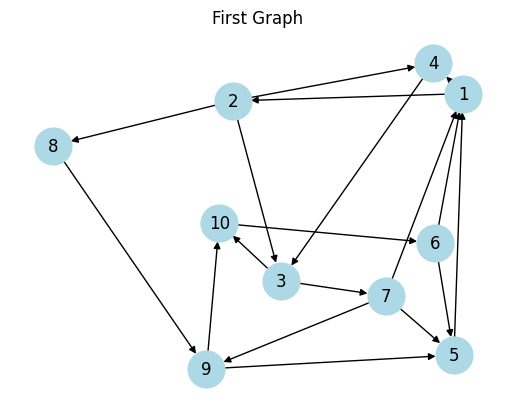

#### Grafo minimizado

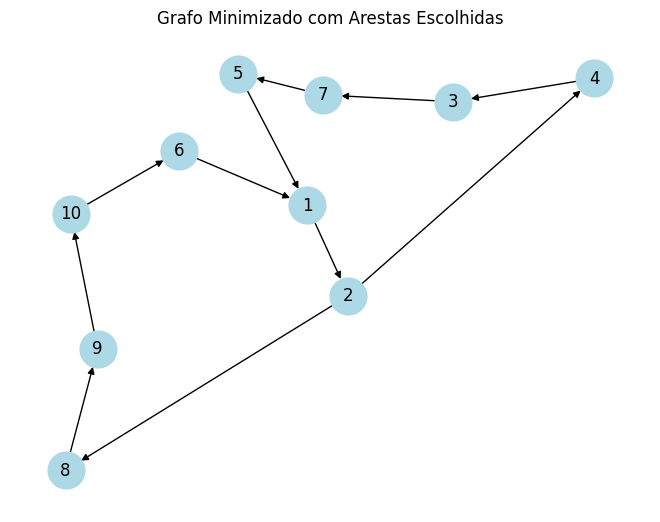

### Exemplo 2

Num_Nodes = 7

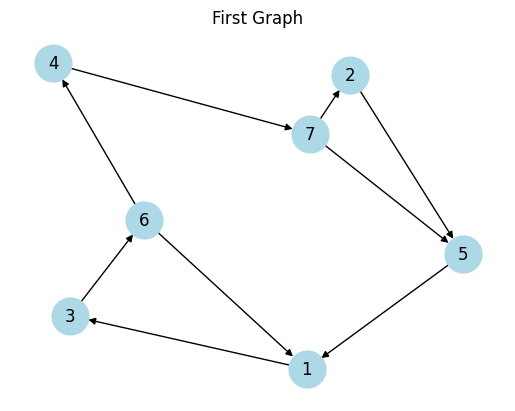

#### Grafo minimizado

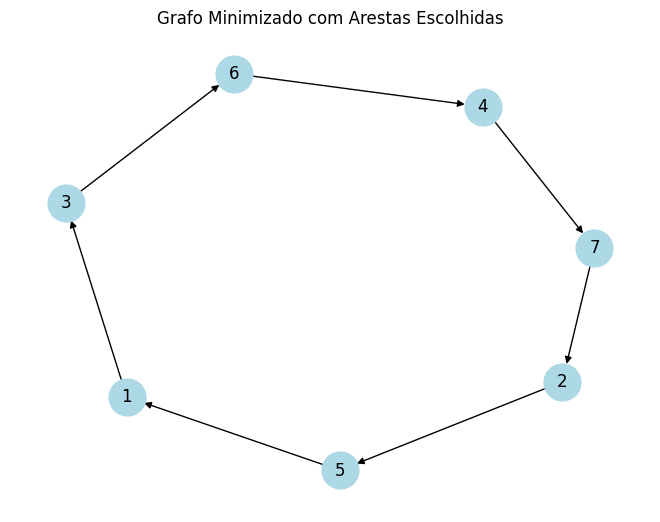